In [103]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.optimize import minimize
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import entropy
import random

In [104]:
#load COSMIC mutational signature data
df_sig = pd.read_csv("COSMIC_v3.3.1_SBS_GRCh37.txt", sep="\t")
random.seed(42)

#configuration and constants

#total number of mutations in a sample
variants = 100

#number of samples to be generated
num_data = 50


#contributions dictionary
base_contributions = {
    "SBS1": 25,
    "SBS18": 8,
    "SBS32": 4,
    "SBS37": 4,
    "SBS39": 3
}

#peaky profile
peaky_contributions = {
    "SBS1": 25,
    "SBS18": 10,
    "SBS32": 10,
    "SBS37": 5,
    "SBS39": 5
}

#flat profile
flat_contributions = {
    "SBS1": 1,
    "SBS18": 20,
    "SBS32": 2,
    "SBS37": 20,
    "SBS39": 20
}

Helper functions

In [105]:
#function to simulate genetic mutation data based on reference mutational signatures
def generate_data(num_variants, num_sets, contributions, ref_sigs):
    """
    Generate datasets of mutations based on given contributions and reference signatures.
    Returns list of datasets.
    """
    # datasets list
    datasets = []
    for n in range(num_sets):
        coeffs = {}
        for s_ in contributions:
            coeffs[s_] = contributions[s_]
        total = sum(coeffs.values())

        # build die
        weights = np.zeros(96)
        for s_ in coeffs:
            c_ = coeffs[s_] / total
            weights += c_ * ref_sigs[s_].values

        # build data        
        data = np.random.choice(np.arange(96), size=num_variants, replace=True, p=weights)

        # store dataset in list
        data_dic = {
            "substitution": df_sig['Type'].values,
            "frequency": [np.count_nonzero(data == i) for i in range(96)]
        }
        dataframe = pd.DataFrame(data_dic)
        
        # Calculate 'p' column
        dataframe['p'] = dataframe['frequency'] / dataframe['frequency'].sum()
        datasets.append(dataframe)
    return datasets


#objective function to calculate L2 norm (Euclidean distance) for optimization
def objective_function_l2(c, m, S):
    """
    Compute the L2 norm (Euclidean distance) for optimization.
    """    
    return np.linalg.norm(m - np.dot(c, S), ord=2)


#function to fit mutational signatures to samples
def fit_signatures(sample, ref, cost_fn):
    """
    Fit mutational signatures to samples using optimization.
    Returns the optimization result.
    """
    S = ref.select_dtypes(include=np.number)
    n_sigs = len(S.columns)
    S = np.array(S.values.tolist())
    m = sample['p'].to_numpy()
    c0 = np.ones((n_sigs, )) / n_sigs
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
    bounds = [(0, 1) for i in range(n_sigs)]
    result = minimize(cost_fn, c0, args=(m, S.T), method='SLSQP', bounds=bounds, constraints=constraints)
    return result

#function to retrieve contributions of each signature after fitting
def get_contributions(res, ref):
    """
    Retrieve contributions of each signature after fitting.
    Returns a DataFrame with contributions sorted by value.
    """
    columns = ref.select_dtypes(include=np.number).columns    
    contri = pd.DataFrame({'Signatures' : columns, 'Contribution' : res.x.tolist()})
    contri = contri.sort_values(by = ['Contribution'], ascending = False, ignore_index=True)
    return contri


#function to compute cosine similarity between observed and predicted mutations
def optimized_get_cosine_sim(samples, ref, cost_fn):
    """
    Calculate the cosine similarity between observed and predicted mutations.
    Returns a list of cosine similarity values.
    """
    cosine_sim_values = []
    count = len(samples)
    signatures = ref.select_dtypes(include=np.number).columns.to_list()
    for i in range(count):
        res = fit_signatures(samples[i], ref, cost_fn)
        contri = get_contributions(res, ref)
        calc_contribution = np.zeros(96,)
        for j in range(len(contri)):
            calc_contribution += ref[contri['Signatures'][j]].to_numpy() * contri['Contribution'][j]
        original_p = samples[i]['p'].to_numpy().reshape(1, -1)
        cosine_sim = cosine_similarity(calc_contribution.reshape(1, -1), original_p)[0][0]
        cosine_sim_values.append(cosine_sim)
    return cosine_sim_values


#function to compute entropy of a sample's mutation frequencies
def calculate_entropy(sample):
    """
    Compute the entropy of a sample's mutation frequencies.
    """
    return entropy(sample['p'], base=2)

    
#function to compute peakiness of the sample using entropy
def get_peakiness(sample):
    """
    Compute the peakiness of the sample using entropy.
    """
    return 1 / calculate_entropy(sample)


#function to gather data on cosine similarity over a range of mutation counts
def gather_data_for_variants_range_with_std_cosine(start, end, interval, contributions, df_sig, ref, cost_fn):
    """
    Gather data on cosine similarity over a range of mutation counts.
    Returns variant counts, average cosine similarity values, and standard deviation values.
    """
    variant_counts = list(range(start, end + 1, interval))
    cosine_sim_values_avg = []
    cosine_sim_std_values = []
    
    for count in variant_counts:
        samples = generate_data(count, num_data, contributions, df_sig)
        cosine_sim_values = optimized_get_cosine_sim(samples, ref, cost_fn)
        cosine_sim_values_avg.append(np.mean(cosine_sim_values))
        cosine_sim_std_values.append(np.std(cosine_sim_values))
    
    return variant_counts, cosine_sim_values_avg, cosine_sim_std_values


#function to plot cosine similarity against mutation counts with error bars
def plot_variants_vs_cosine_sim_with_errorbars(variant_counts, cosine_sim_values, cosine_sim_std_values):
    """
    Plot cosine similarity against mutation counts with error bars.
    """
    plt.figure(figsize=(10, 6))
    plt.errorbar(variant_counts, cosine_sim_values, yerr=cosine_sim_std_values, color='black', ecolor='red', 
                 fmt='o', capsize=5, alpha=0.7)
    plt.title("Mean Cosine Similarity vs Mutations counts (with Error Bars)")
    plt.xlabel("Mutation counts")
    plt.ylabel("Average Cosine Similarity")
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


#function to transition contributions from peaky to flat
def generate_peakiness_contributions(peaky_contributions, flat_contributions, steps = 100):
    """
    Gradually transition the contributions dictionary from peaky to flat configuration in the given number of steps.
    Returns a list of varied contributions configurations.
    """
    varied_contributions = []
    for i in range(steps):
        temp_contrib = {}
        for key in peaky_contributions:
            temp_contrib[key] = peaky_contributions[key] + i * (flat_contributions[key] - peaky_contributions[key]) / (steps - 1)
        varied_contributions.append(temp_contrib)
    return varied_contributions   


#function to gather data on the relationship between peakiness and accuracy
def gather_data_peakiness_vs_accuracy_with_std(peaky_contributions, flat_contributions, df_sig, ref, cost_fn):
    """
    Gather data on the relationship between peakiness and accuracy.
    Returns peakiness values, average cosine similarity values, and standard deviation values.
    """
    varied_contributions_list = generate_peakiness_contributions(peaky_contributions, flat_contributions)
    peakiness_values = []
    cosine_sim_avg_values = []
    cosine_sim_std_values = []
    
    for contributions in varied_contributions_list:
        temp_cosine_sims = []        
        sample = generate_data(variants, 1, contributions, df_sig)[0]
        peakiness = get_peakiness(sample)
        cosine_sim = optimized_get_cosine_sim([sample], ref, cost_fn)[0]
        temp_cosine_sims.append(cosine_sim)
        peakiness_values.append(peakiness)
        cosine_sim_avg_values.append(np.mean(temp_cosine_sims))
        cosine_sim_std_values.append(np.std(temp_cosine_sims))
    return peakiness_values, cosine_sim_avg_values, cosine_sim_std_values

#function to help plot confidence intervals
def bootstrap_lowess(x, y, it=100, alpha=0.95):
    #list to store bootstrapped LOWESS results
    bootstrapped = []
    
    #lonvert x and y to numpy arrays for easier indexing
    x = np.array(x)
    y = np.array(y)
    
    #iterate specified number of times to perform bootstrapping
    for _ in range(it):
        # Generate random indices with replacement
        indices = np.random.choice(len(x), len(x), replace=True)
        # Calculate LOWESS for the randomly selected data points and append the y-values to bootstrapped list
        bootstrapped.append(lowess(y[indices], x[indices])[:, 1])
    
    #convert bootstrapped results to a numpy array
    bootstrapped = np.array(bootstrapped)

    #compute the lower bound of the confidence interval
    lower = np.percentile(bootstrapped, (1.0 - alpha) / 2.0 * 100, axis=0)
    
    #compute the upper bound of the confidence interval
    upper = np.percentile(bootstrapped, (1.0 + alpha) / 2.0 * 100, axis=0)
    
    #return the lower and upper bounds of the confidence intervals
    return lower, upper

In [107]:
#merging and preparing reference signatures
merged_df = pd.merge(generate_data(variants, 1, base_contributions, df_sig)[0], df_sig, left_on='substitution', right_on='Type')  
ref_sig = merged_df.drop(columns=['substitution', 'frequency', 'p'])

#gathering the data for cosine similarity with standard deviations and plotting the scatter graph
peakiness_vals, cosine_sim_avg_vals, cosine_sim_std_vals = gather_data_peakiness_vs_accuracy_with_std(peaky_contributions, flat_contributions, df_sig, ref_sig, objective_function_l2)

Scatterplot of cosine similarity vs peakiness (with lowess curve)

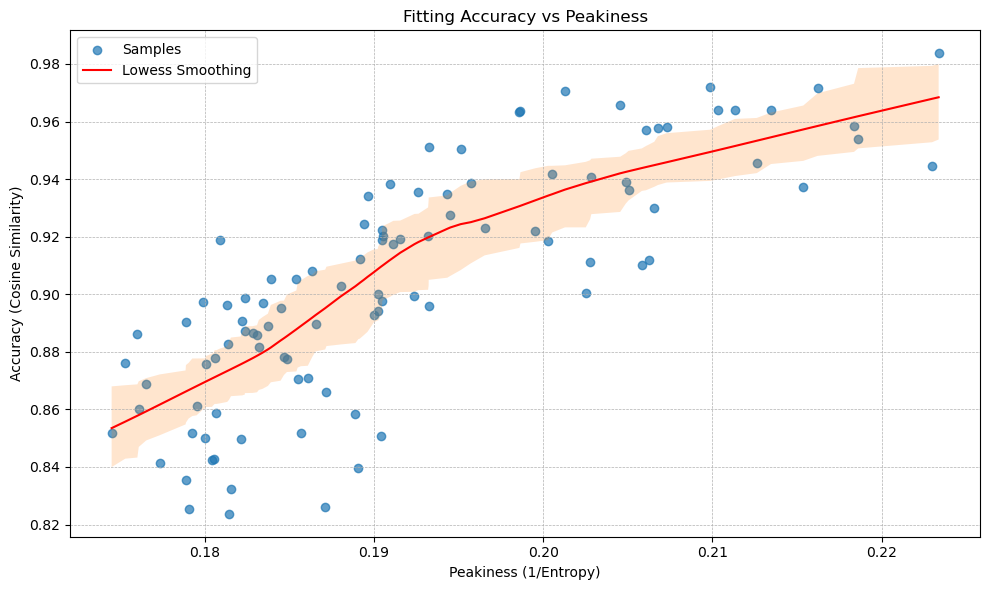

In [108]:
from statsmodels.nonparametric.smoothers_lowess import lowess

#Use lowess to get a smoothed line
smoothed = lowess(cosine_sim_avg_vals, peakiness_vals)  # The frac parameter controls the degree of smoothing

#Plot
plt.figure(figsize=(10, 6))
plt.scatter(peakiness_vals, cosine_sim_avg_vals, alpha=0.7, label='Samples')
plt.plot(smoothed[:, 0], smoothed[:, 1], color='red', label='Lowess Smoothing')
#bootstrap to get the confidence intervals
lower, upper = bootstrap_lowess(peakiness_vals, cosine_sim_avg_vals)
    
#plot the smoothed curve and the confidence intervals
plt.fill_between(smoothed[:, 0], lower, upper, alpha=0.2)
plt.title("Fitting Accuracy vs Peakiness")
plt.xlabel("Peakiness (1/Entropy)")
plt.ylabel("Accuracy (Cosine Similarity)")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

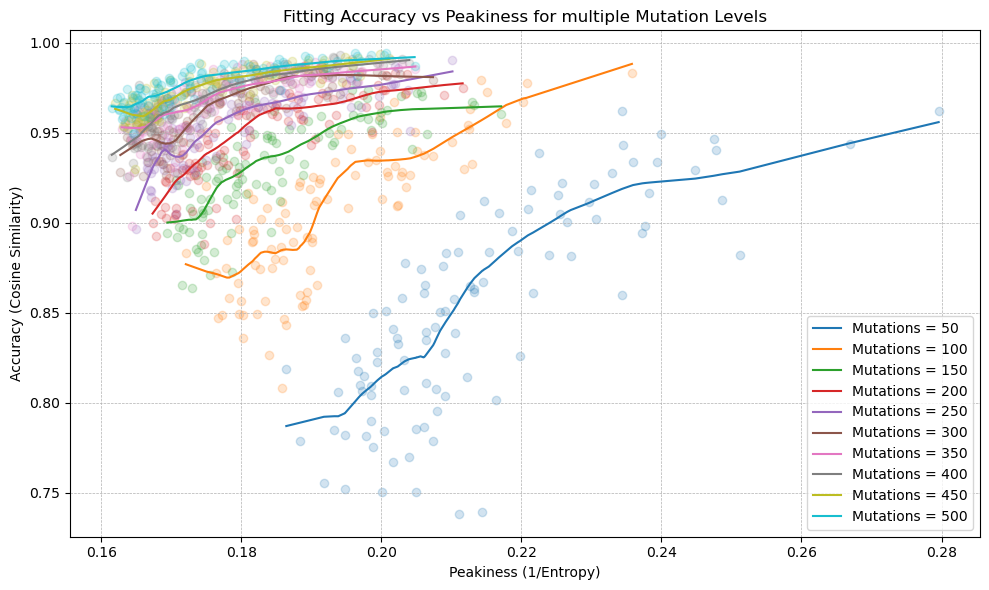

In [45]:
#Set up the plot
plt.figure(figsize=(10, 6))

#Loop over variants from 50 to 500 in intervals of 50
for variants in range(50, 501, 50):
    #generate and process the data
    peakiness_vals, cosine_sim_avg_vals, _ = gather_data_peakiness_vs_accuracy_with_std(peaky_contributions, flat_contributions, df_sig, ref_sig, objective_function_l2)
    
    #add scatter plot with reduced opacity
    plt.scatter(peakiness_vals, cosine_sim_avg_vals, alpha=0.2)
    
    #compute the lowess smoothed curve
    z = lowess(cosine_sim_avg_vals, peakiness_vals, frac=0.3)
    
    #plot the smoothed curve for the current number of variants
    plt.plot(z[:, 0], z[:, 1], label=f'Mutations = {variants}')

#Set plot details and display
plt.title("Fitting Accuracy vs Peakiness for multiple Mutation Levels")
plt.xlabel("Peakiness (1/Entropy)")
plt.ylabel("Accuracy (Cosine Similarity)")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

with Confidence intervals

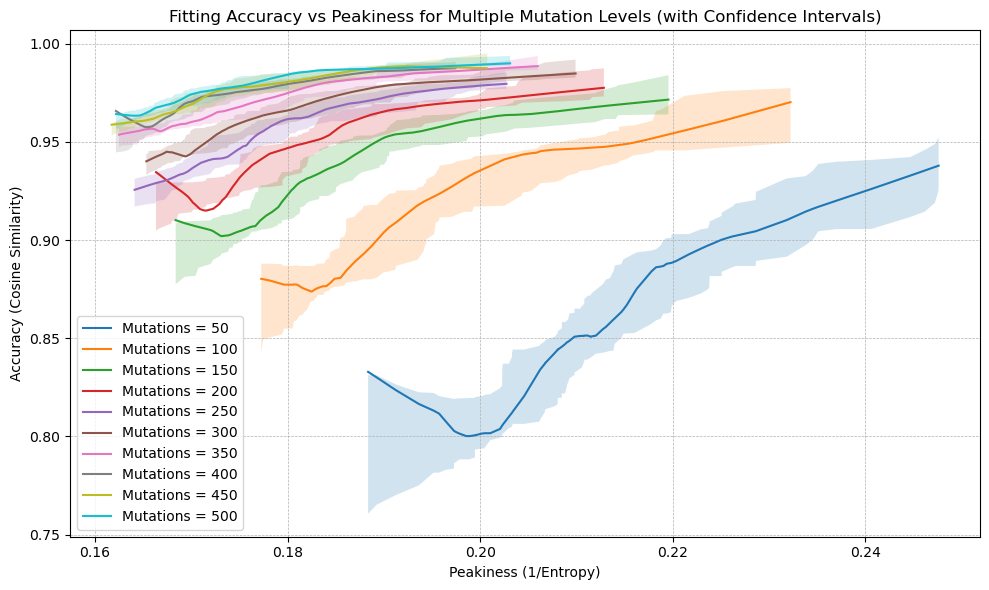

In [109]:
#Set up the plot
plt.figure(figsize=(10, 6))

#Loop over variants from 50 to 500 in intervals of 50
for variants in range(50, 501, 50):
    #Generate and process the data
    peakiness_vals, cosine_sim_avg_vals, _ = gather_data_peakiness_vs_accuracy_with_std(peaky_contributions, flat_contributions, df_sig, ref_sig, objective_function_l2)
    
    #Compute the lowess smoothed curve
    z = lowess(cosine_sim_avg_vals, peakiness_vals, frac=0.3)
    
    #bootstrap to get the confidence intervals
    lower, upper = bootstrap_lowess(peakiness_vals, cosine_sim_avg_vals)
    
    #plot the smoothed curve and the confidence intervals
    plt.plot(z[:, 0], z[:, 1], label=f'Mutations = {variants}')
    plt.fill_between(z[:, 0], lower, upper, alpha=0.2)

#set plot details and display
plt.title("Fitting Accuracy vs Peakiness for Multiple Mutation Levels (with Confidence Intervals)")
plt.xlabel("Peakiness (1/Entropy)")
plt.ylabel("Accuracy (Cosine Similarity)")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [20]:
#Gathering the data for cosine similarity with standard deviations in a range
variant_counts, cosine_sim_avg, cosine_sim_std = gather_data_for_variants_range_with_std_cosine(50, 500, 50, base_contributions, df_sig, ref_sig, objective_function_l2)

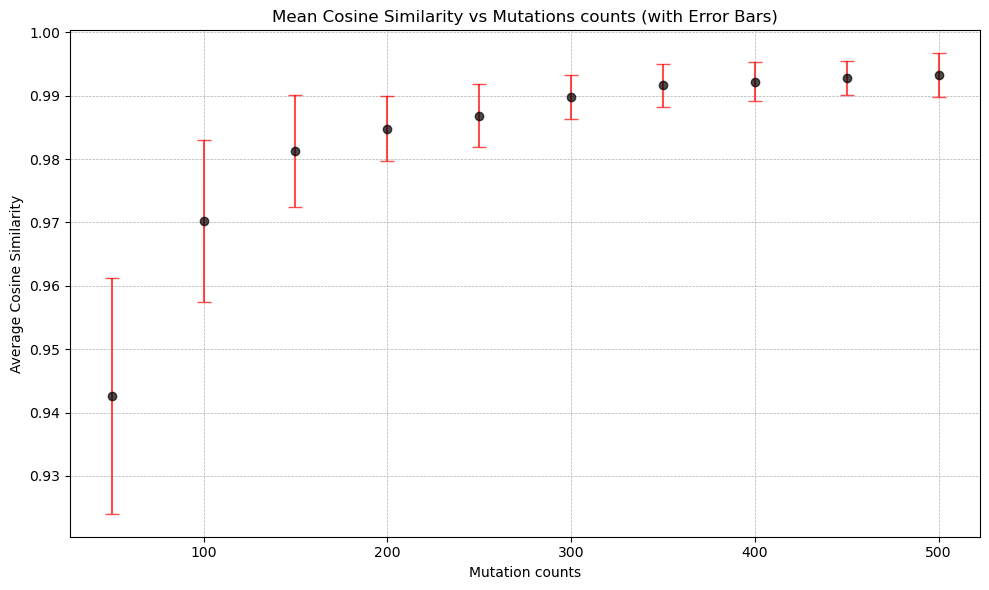

In [21]:
#scatter plot with error bars
plot_variants_vs_cosine_sim_with_errorbars(variant_counts, cosine_sim_avg, cosine_sim_std)

For the table

In [116]:
# List to hold the results
results_data = {
    "Mutation counts": [],
    "Peakiness (Average)": [],
    "Cosine Similarity (Average)": [],
    "Cosine Similarity (Standard Deviation)": []
}

# Loop over variants from 50 to 500 in intervals of 50
for variants in range(50, 501, 50):
    # Generate and process the data
    peakiness_vals, cosine_sim_avg_vals, cosine_sim_std_vals = gather_data_peakiness_vs_accuracy_with_std(peaky_contributions, flat_contributions, df_sig, ref_sig, objective_function_l2)
    
    # Append the data to the results_data dictionary
    results_data["Mutation counts"].append(variants)
    results_data["Peakiness (Average)"].append(np.mean(peakiness_vals))
    results_data["Cosine Similarity (Average)"].append(np.mean(cosine_sim_avg_vals))
    results_data["Cosine Similarity (Standard Deviation)"].append(np.std(cosine_sim_avg_vals))

# Convert the results_data dictionary into a DataFrame for better visualization and further analysis
results_df = pd.DataFrame(results_data)

# Display the DataFrame
print(results_df)


   Mutation counts  Peakiness (Average)  Cosine Similarity (Average)  \
0               50             0.212398                     0.846982   
1              100             0.192501                     0.906561   
2              150             0.186076                     0.932437   
3              200             0.180702                     0.942290   
4              250             0.179700                     0.955195   
5              300             0.178275                     0.962238   
6              350             0.176919                     0.966656   
7              400             0.175998                     0.969829   
8              450             0.174983                     0.973759   
9              500             0.174664                     0.976475   

   Cosine Similarity (Standard Deviation)  
0                                0.055093  
1                                0.038690  
2                                0.030512  
3                              

In [117]:
results_df

,Mutation counts,Peakiness (Average),Cosine Similarity (Average),Cosine Similarity (Standard Deviation)
0,50,0.212398,0.846982,0.055093
1,100,0.192501,0.906561,0.038690
2,150,0.186076,0.932437,0.030512
3,200,0.180702,0.942290,0.026779
4,250,0.179700,0.955195,0.020090
5,300,0.178275,0.962238,0.017744
6,350,0.176919,0.966656,0.015223
7,400,0.175998,0.969829,0.015022
8,450,0.174983,0.973759,0.011982
9,500,0.174664,0.976475,0.011102
